In [1]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.ticker import FuncFormatter, MultipleLocator

import numpy
from numpy import sin, cos, sqrt, pi, array, radians, log10

from earth import earth_radius as radius
from basic import angular_to_cartesian as cartesian
import summary

from plot import enable_seaborn
seaborn = enable_seaborn()


numpy.set_printoptions(precision=4, suppress=True)

In [2]:
# in units of Pa
mu = 2.6 * (10 ** 10)
kappa = 5.2 * (10 ** 10)
lamda = kappa - 2. * mu / 3.

# without units
zhat = array([0, 0, 1])

def moment_magnitude(scalar_moment):
    # scalar moment is in N m
    M0 = scalar_moment * 10 ** 7
    return 2. * log10(M0) / 3. - 10.7


def plane_to_sphere(x, y):
    theta = sqrt(x ** 2 + y ** 2) / radius
    phi = numpy.arctan2(y, x)
    
    return theta, phi


class Okada(object):
    def __init__(self, point, d, delta):
        self.point = point
        self.d = d
        self.delta = delta

        x, y, z = point
        self.p = y * cos(delta) + self.d * sin(delta)
        self.q = y * sin(delta) - self.d * cos(delta)        
        self.R = sqrt(x ** 2 + y ** 2 + d ** 2)
        R = self.R
        
        coeff = mu / (lamda + mu)
        first = 1 / (R * (R + d) ** 2)
        second = (3 * R + d) / (R ** 3 * (R + d) ** 3)
        third = (2 * R + d) / (R ** 3 * (R + d) ** 2)
        fourth = 1 / (R * (R + d))
        
        self.I_1 = coeff * y * (first - x**2 * second)
        self.I_2 = coeff * x * (first - y**2 * second)
        self.I_3 = coeff * (x / R ** 3) - self.I_2
        self.I_4 = coeff * (-x * y * third)
        self.I_5 = coeff * (fourth - x ** 2 * third)
        
    def strike_slip(self):
        x, y, z = self.point
        q, R, d = self.q, self.R, self.d * numpy.ones_like(x)
        delta = self.delta
        I_1, I_2, I_4 = self.I_1, self.I_2, self.I_4
        
        return -(3. * x * q * array([x, y, d]) / R ** 5 +
                 array([I_1, I_2, I_4]) * sin(delta)) / (2. * pi) 
    
    def dip_slip(self):
        x, y, z = self.point
        q, R, d, p = self.q, self.R, self.d * numpy.ones_like(x), self.p
        delta = self.delta
        I_1, I_3, I_5 = self.I_1, self.I_3, self.I_5
        return -((3. * p * q * array([x, y, d]) / R ** 5 -
                 array([I_3, I_1, I_5]) * sin(delta) * cos(delta)) /
                 (2. * pi))
    
    def tensile_slip(self):
        x, y, z = self.point
        q, R, d = self.q, self.R, self.d * numpy.ones_like(x)
        delta = self.delta
        I_1, I_3, I_5 = self.I_1, self.I_3, self.I_5

        return (3. * q ** 2 * array([x, y, d]) / R ** 5 -
                 array([I_3, I_1, I_5]) * sin(delta) ** 2) / (2. * pi) 


In [3]:
# in degrees
delta = 0.

# in m
d = 10000

# in m
delta_u = 136.5 /sqrt(2)
L = 100000
W = 100000
Sigma = L * W

moment = mu * delta_u * Sigma * sqrt(2)
print(moment_magnitude(moment))

scale = 20000

x, y = numpy.meshgrid(numpy.linspace(-scale, scale, 100), 
                      numpy.linspace(-scale, scale, 100))

z = numpy.zeros_like(x)

theta, phi = plane_to_sphere(x, y)
phi[phi < 0] += 2. * numpy.pi 

okada = Okada(array([x, y, z]), d, radians(delta))

9.00007066623


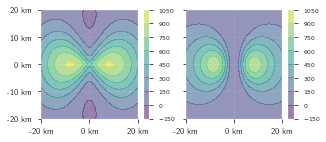

In [4]:
formatter = FuncFormatter(lambda x, ps: r"{0:g} km".format(x / 1000))

fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2), sharey=True)

folder = '../data/bigger/dc-1/10/'
options = summary.read_options(folder)

field = summary.binary_to_field(folder)

u = field.interpolate(options)

ux = array([[u(theta[i, j], phi[i, j])[0] for j in range(theta.shape[1])] 
                for i in range(theta.shape[0])]) / 100

axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))
axes[0].yaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))

CS = axes[0].contourf(x, y, ux, cmap='viridis', alpha=0.5)
for tick in axes[0].get_yticklabels():
    break
font = tick.get_font_properties()

cb = pyplot.colorbar(CS, ax=axes[0])
for tick in cb.ax.get_yticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)
    

ux, uy, uz = (delta_u * Sigma) * okada.strike_slip()
axes[1].xaxis.set_major_locator(MultipleLocator(20000))
axes[1].xaxis.set_major_formatter(formatter)
CS = axes[1].contourf(x, y, ux, CS.levels, cmap='viridis', alpha=0.5)
cb = pyplot.colorbar(CS, ax=axes[1])
for tick in cb.ax.yaxis.get_ticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)

pyplot.savefig('figures/thesis-okada.pdf', bbox_inches='tight')


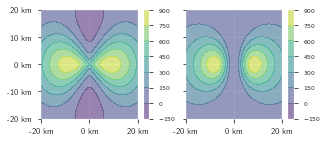

In [5]:
formatter = FuncFormatter(lambda x, ps: r"{0:g} km".format(x / 1000))

fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2), sharey=True)

folder = '../data/okada-good-copy/'
options = summary.read_options(folder)

field = summary.binary_to_field(folder)

u = field.interpolate(options)

ux = array([[u(theta[i, j], phi[i, j])[0] for j in range(theta.shape[1])] 
                for i in range(theta.shape[0])]) / 100

axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))
axes[0].yaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(MultipleLocator(20000))

#for tick in axes[0].xaxis.get_ticklabels():
#    tick.set_fontsize(7)

#for tick in axes[0].yaxis.get_ticklabels():
#    tick.set_fontsize(7)

CS = axes[0].contourf(x, y, ux, cmap='viridis', alpha=0.5)
for tick in axes[0].get_yticklabels():
    break
font = tick.get_font_properties()

cb = pyplot.colorbar(CS, ax=axes[0])
for tick in cb.ax.get_yticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)
    

ux, uy, uz = (delta_u * Sigma) * okada.strike_slip()
axes[1].xaxis.set_major_locator(MultipleLocator(20000))
axes[1].xaxis.set_major_formatter(formatter)

#for tick in axes[1].xaxis.get_ticklabels():
#    tick.set_fontsize(7)

CS = axes[1].contourf(x, y, ux, CS.levels, cmap='viridis', alpha=0.5)
cb = pyplot.colorbar(CS, ax=axes[1])
for tick in cb.ax.yaxis.get_ticklabels():
    tick.set_usetex(False)
    tick.set_fontsize(6)

pyplot.savefig('figures/thesis-okada.pdf', bbox_inches='tight')
